# Лабораторная работа №7 по курсу "Нейроинформатика".
Выполнил Пищик Е.С. М8О-406Б-19.

## Цель работы.

Исследование свойств автоассоциативных сетей с узким горлом, алгоритмов обучения, а также применение сетей для выполнения линейного и нелинейного анализа главных компонент набора данных.

In [176]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from collections import OrderedDict
from torchvision.datasets import MNIST, CIFAR10
from torch.utils.data import DataLoader
from torch.optim import Adam
import torchvision.transforms as transforms
import random

## Linear AutoEncoder.

In [191]:
bs = 64
epochs = 1000
lr = 0.001
pe = 100
wd = 0.00001
split = 0.01
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

In [192]:
dataset = MNIST(root='.', download=True, train=True, transform=transforms.ToTensor())
dataset, _ = torch.utils.data.random_split(dataset, [int(split * len(dataset)), int((1.0 - split) * len(dataset))])
dataloader = DataLoader(dataset, batch_size=bs, shuffle=True)

In [193]:
class AutoEncoder(nn.Module):
    def __init__(self, size, down_channels, up_channels):
        super().__init__()
        
        encoder_layers = [('flatten', torch.nn.Flatten())]
        decoder_layers = []

        for idx, (in_channels, out_channels) in enumerate(zip(down_channels[:-1], down_channels[1:])):
            encoder_layers.append((f'linear{idx + 1}', nn.Linear(in_channels, out_channels)))
            if idx != len(down_channels[:-1]) - 1:
                encoder_layers.append((f'sigmoid{idx + 1}', nn.Sigmoid()))
        
        for idx, (in_channels, out_channels) in enumerate(zip(up_channels[:-1], up_channels[1:])):
            decoder_layers.append((f'linear{idx + 1}', nn.Linear(in_channels, out_channels)))
            decoder_layers.append((f'sigmoid{idx + 1}', nn.Sigmoid()))
        decoder_layers.append(('unflatten', nn.Unflatten(1, size)))
        
        encoder = nn.Sequential(OrderedDict(encoder_layers))
        decoder = nn.Sequential(OrderedDict(decoder_layers))
        self.autoencoder = nn.Sequential(OrderedDict([('encoder', encoder), ('decoder', decoder)]))
    
    def forward(self, x):
        return self.autoencoder(x)

In [194]:
autoencoder = AutoEncoder((1, 28, 28), [784, 256, 64, 32], [32, 64, 256, 784]).to(device)
optimizer = Adam(autoencoder.parameters(), lr=lr, weight_decay=wd)
criterion = nn.MSELoss()
print(autoencoder)

AutoEncoder(
  (autoencoder): Sequential(
    (encoder): Sequential(
      (flatten): Flatten(start_dim=1, end_dim=-1)
      (linear1): Linear(in_features=784, out_features=256, bias=True)
      (sigmoid1): Sigmoid()
      (linear2): Linear(in_features=256, out_features=64, bias=True)
      (sigmoid2): Sigmoid()
      (linear3): Linear(in_features=64, out_features=32, bias=True)
    )
    (decoder): Sequential(
      (linear1): Linear(in_features=32, out_features=64, bias=True)
      (sigmoid1): Sigmoid()
      (linear2): Linear(in_features=64, out_features=256, bias=True)
      (sigmoid2): Sigmoid()
      (linear3): Linear(in_features=256, out_features=784, bias=True)
      (sigmoid3): Sigmoid()
      (unflatten): Unflatten(dim=1, unflattened_size=(1, 28, 28))
    )
  )
)


In [195]:
def train(model, optimizer, criterion, dataloader, epochs, device, every):
    model.train()

    for ep in range(epochs):
        loss = 0.0

        for image, _ in dataloader:
            x = image.to(device)
            pred_x = model(x)

            crt = criterion(pred_x, x)
            loss += crt.item()

            optimizer.zero_grad()
            crt.backward()
            optimizer.step()
        
        loss /= len(dataloader)

        if (ep + 1) % every == 0:
            print(f'epoch={ep + 1}, loss={loss:.4f}')

In [196]:
train(autoencoder, optimizer, criterion, dataloader, epochs, device, pe)

epoch=100, loss=0.0585
epoch=200, loss=0.0524
epoch=300, loss=0.0469
epoch=400, loss=0.0435
epoch=500, loss=0.0416
epoch=600, loss=0.0394
epoch=700, loss=0.0375
epoch=800, loss=0.0366
epoch=900, loss=0.0353
epoch=1000, loss=0.0346


In [197]:
def plot(dataset, model, device):
    model.eval()

    idx = random.randint(0, len(dataset) - 1)
    image = dataset[idx][0].to(device).unsqueeze(0)

    output = model(image)[0][0]
    output = output.detach().cpu().numpy()

    image = image[0][0].detach().cpu().numpy()

    fig, axes = plt.subplots(1, 2, figsize=(10, 7))

    axes[0].imshow(image, cmap='gray')
    axes[1].imshow(output, cmap='gray')

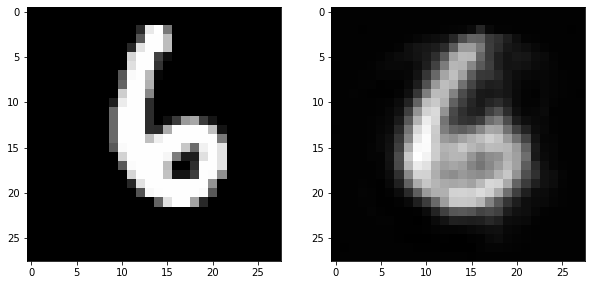

In [198]:
plot(dataset, autoencoder, device)

In [159]:
bs = 64
epochs = 1500
lr = 0.001
wd = 0.00001
pe = 100
split = 0.004
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

In [160]:
dataset = CIFAR10(root='.', download=True, train=True, transform=transforms.ToTensor())
dataset, _ = torch.utils.data.random_split(dataset, [int(split * len(dataset)), int((1.0 - split) * len(dataset))])
dataloader = DataLoader(dataset, batch_size=bs, shuffle=True)

Files already downloaded and verified


In [166]:
autoencoder = AutoEncoder((3, 32, 32), [3072, 1024, 128], [128, 1024, 3072]).to(device)
optimizer = Adam(autoencoder.parameters(), lr=lr, weight_decay=wd)
criterion = nn.MSELoss()
print(autoencoder)

AutoEncoder(
  (autoencoder): Sequential(
    (encoder): Sequential(
      (flatten): Flatten(start_dim=1, end_dim=-1)
      (linear1): Linear(in_features=3072, out_features=1024, bias=True)
      (sigmoid1): Sigmoid()
      (linear2): Linear(in_features=1024, out_features=128, bias=True)
    )
    (decoder): Sequential(
      (linear1): Linear(in_features=128, out_features=1024, bias=True)
      (sigmoid1): Sigmoid()
      (linear2): Linear(in_features=1024, out_features=3072, bias=True)
      (sigmoid2): Sigmoid()
      (unflatten): Unflatten(dim=1, unflattened_size=(3, 32, 32))
    )
  )
)


In [167]:
train(autoencoder, optimizer, criterion, dataloader, epochs, device, pe)

epoch=100, loss=0.0269
epoch=200, loss=0.0210
epoch=300, loss=0.0140
epoch=400, loss=0.0133
epoch=500, loss=0.0133
epoch=600, loss=0.0107
epoch=700, loss=0.0104
epoch=800, loss=0.0097
epoch=900, loss=0.0105
epoch=1000, loss=0.0106
epoch=1100, loss=0.0091
epoch=1200, loss=0.0096
epoch=1300, loss=0.0088
epoch=1400, loss=0.0104
epoch=1500, loss=0.0088


In [168]:
def plot(dataset, model, device):
    model.eval()

    idx = random.randint(0, len(dataset) - 1)
    image = dataset[idx][0].to(device).unsqueeze(0)

    output = model(image)[0]
    output = np.transpose(output.detach().cpu().numpy(), (1, 2, 0))

    image = np.transpose(image[0].detach().cpu().numpy(), (1, 2, 0))

    fig, axes = plt.subplots(1, 2, figsize=(10, 7))

    axes[0].imshow(image)
    axes[1].imshow(output)

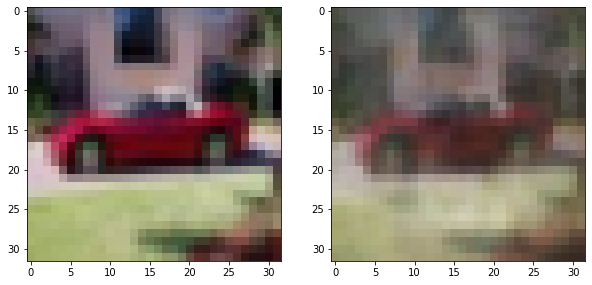

In [175]:
plot(dataset, autoencoder, device)

## Выводы.

В данной лабораторной работе мы научились работать с автоассоциативными моделями с узким горлом.